# ЗАДАНИЕ 10. ПОСТРОЕНИЕ МОДЕЛИ ХОЛЬТА-УИНТЕРСА И МОДЕЛИ ТЕЙЛА-ВЕЙДЖА

https://www.statsmodels.org/stable/examples/notebooks/generated/exponential_smoothing.html

In [42]:
import os
import pandas as pd 
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy.optimize import differential_evolution, minimize
import scipy

In [43]:
os.chdir("C:/Users/HP/Documents/analysis/TS/data/")

In [44]:
data = pd.read_excel('data.xls', sheet_name='Prices')
data.head()

,Unnamed: 0,Unnamed: 1,Рыночные цены на продукцию (руб.),Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49
0,NaN,NaN,2007-01-01 00:00:00,2007-02-01 00:00:00,2007-03-01 00:00:00,2007-04-01 00:00:00,2007-05-01 00:00:00,2007-06-01 00:00:00,2007-07-01 00:00:00,2007-08-01 00:00:00,...,2010-03-01 00:00:00,2010-04-01 00:00:00,2010-05-01 00:00:00,2010-06-01 00:00:00,2010-07-01 00:00:00,2010-08-01 00:00:00,2010-09-01 00:00:00,2010-10-01 00:00:00,2010-11-01 00:00:00,2010-12-01 00:00:00
1,№ организации,1.0,61.75,58.66,52.67,42.45,41.96,39.6,38.81,55.68,...,80.53,75.52,71.61,65.58,65.41,67.65,66.87,71.7,76.25,82.23
2,NaN,2.0,153.4,149.4,144.16,135.57,132.99,131.5,130.85,136.7,...,171.73,167.74,162.16,156.61,158.25,160.48,156.98,163.53,168.33,175.26
3,NaN,3.0,105.94,103.88,97.72,88.95,87.24,83.96,83.27,89.8,...,126.25,119.78,115.19,110.53,110.12,112.93,111.69,115.19,122.9,128.68
4,NaN,4.0,150.03,155.82,151.17,141.74,149.15,146.48,148.33,153.19,...,198.09,194.57,188.31,184.41,183.69,187.48,184.97,189.35,205.11,210.82


In [45]:
dates = data.loc[data.index == 0].values[0, 2:]
val = data.loc[data.index == 1].values[0, 2:]

In [46]:
data={"Date": dates, "Value": val}

In [47]:
my_data = pd.DataFrame(data)
my_data.head()

,Date,Value
0,2007-01-01,61.75
1,2007-02-01,58.66
2,2007-03-01,52.67
3,2007-04-01,42.45
4,2007-05-01,41.96


In [48]:
my_data=my_data.set_index('Date')
my_data.head()

,Value
Date,
2007-01-01,61.75
2007-02-01,58.66
2007-03-01,52.67
2007-04-01,42.45
2007-05-01,41.96


In [49]:
my_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2007-01-01 to 2010-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Value   48 non-null     object
dtypes: object(1)
memory usage: 768.0+ bytes


In [50]:
my_data.Value=my_data.Value.astype(float)

In [51]:
my_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2007-01-01 to 2010-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   48 non-null     float64
dtypes: float64(1)
memory usage: 768.0 bytes


## Построим модель Хольта-Уинтерса

In [52]:
tidx = pd.DatetimeIndex(my_data.index, freq='infer')
tidx

DatetimeIndex(['2007-01-01', '2007-02-01', '2007-03-01', '2007-04-01',
               '2007-05-01', '2007-06-01', '2007-07-01', '2007-08-01',
               '2007-09-01', '2007-10-01', '2007-11-01', '2007-12-01',
               '2008-01-01', '2008-02-01', '2008-03-01', '2008-04-01',
               '2008-05-01', '2008-06-01', '2008-07-01', '2008-08-01',
               '2008-09-01', '2008-10-01', '2008-11-01', '2008-12-01',
               '2009-01-01', '2009-02-01', '2009-03-01', '2009-04-01',
               '2009-05-01', '2009-06-01', '2009-07-01', '2009-08-01',
               '2009-09-01', '2009-10-01', '2009-11-01', '2009-12-01',
               '2010-01-01', '2010-02-01', '2010-03-01', '2010-04-01',
               '2010-05-01', '2010-06-01', '2010-07-01', '2010-08-01',
               '2010-09-01', '2010-10-01', '2010-11-01', '2010-12-01'],
              dtype='datetime64[ns]', name='Date', freq='MS')

In [53]:
my_data['Value'].index=tidx

In [54]:
model=ExponentialSmoothing(my_data['Value'],seasonal='multiplicative',initialization_method="estimated").fit()

In [55]:
y_pred=model.fittedvalues
y_pred.head()

Date
2007-01-01    61.684354
2007-02-01    60.665997
2007-03-01    55.188165
2007-04-01    49.090043
2007-05-01    39.494559
Freq: MS, dtype: float64

In [56]:
y=my_data['Value']
y.head()

Date
2007-01-01    61.75
2007-02-01    58.66
2007-03-01    52.67
2007-04-01    42.45
2007-05-01    41.96
Freq: MS, Name: Value, dtype: float64

In [57]:
MSE = mean_squared_error(y, y_pred)
print('MSE: %f' % MSE)

MSE: 8.328777


In [58]:
# calculate root mean squared error
RMSE = sqrt(MSE)
print('RMSE: %f' % RMSE)

RMSE: 2.885962


In [59]:
y_new=model.predict(start=48, end=59)
y_new

2011-01-01    79.363854
2011-02-01    77.973304
2011-03-01    73.278008
2011-04-01    68.192742
2011-05-01    63.128272
2011-06-01    58.985805
2011-07-01    59.495122
2011-08-01    65.139420
2011-09-01    67.286470
2011-10-01    73.898658
2011-11-01    77.512462
2011-12-01    82.184530
Freq: MS, dtype: float64

In [60]:
y_new=model.forecast(12)
y_new

2011-01-01    79.363854
2011-02-01    77.973304
2011-03-01    73.278008
2011-04-01    68.192742
2011-05-01    63.128272
2011-06-01    58.985805
2011-07-01    59.495122
2011-08-01    65.139420
2011-09-01    67.286470
2011-10-01    73.898658
2011-11-01    77.512462
2011-12-01    82.184530
Freq: MS, dtype: float64

<p><a name="Intervals"></a></p>

# Построение интервального прогноза

$$\frac{\hat{Y_i}-Y_i}{\sigma} \sim T(n) $$ 
где $$\sigma^2 = \frac{\sum_{i=1}^{n}(Y_i-\hat{Y_i})^2}{n-1} $$
-выборочная дисперсия
$$ P(-T_{n,\alpha} < \frac{\hat{Y_i}-Y_i}{\sigma} < T_{n,\alpha} ) = \alpha $$
$$ \left (\hat{Y_i} -T_{n,\alpha}\cdot \sigma \leq Y_i \leq \hat{Y_i} +T_{n,\alpha}\cdot \sigma \right ) $$

In [61]:
sigma=scipy.stats.sem(y)
sigma

1.585150526992775

In [62]:
confidence=0.95
tstu=scipy.stats.t.ppf((1 + confidence) / 2., len(y)-1)
tstu

2.0117405104757546

In [63]:
y_up=y_new+tstu*sigma
y_up

2011-01-01    82.552766
2011-02-01    81.162215
2011-03-01    76.466919
2011-04-01    71.381654
2011-05-01    66.317184
2011-06-01    62.174717
2011-07-01    62.684034
2011-08-01    68.328331
2011-09-01    70.475381
2011-10-01    77.087569
2011-11-01    80.701373
2011-12-01    85.373441
Freq: MS, dtype: float64

In [64]:
y_down=y_new-tstu*sigma
y_down

2011-01-01    76.174943
2011-02-01    74.784392
2011-03-01    70.089096
2011-04-01    65.003830
2011-05-01    59.939360
2011-06-01    55.796894
2011-07-01    56.306211
2011-08-01    61.950508
2011-09-01    64.097558
2011-10-01    70.709746
2011-11-01    74.323550
2011-12-01    78.995618
Freq: MS, dtype: float64

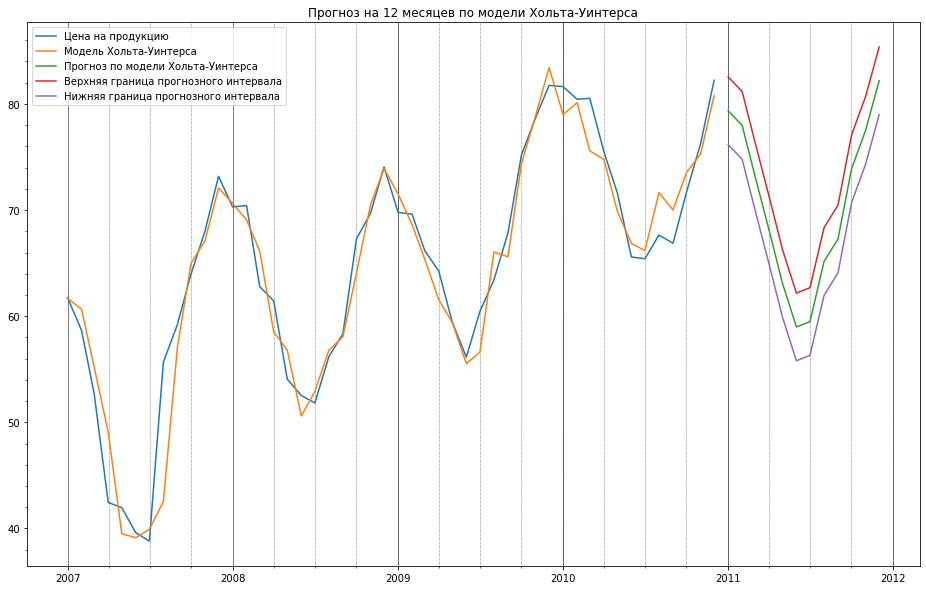

In [65]:
fig, ax = plt.subplots(figsize = (16, 10))

ax.plot(my_data['Value'], label = 'Цена на продукцию')
ax.plot(model.fittedvalues,label = 'Модель Хольта-Уинтерса')
ax.plot(model.predict(start=48, end=59),label = 'Прогноз по модели Хольта-Уинтерса')
ax.plot(y_up, label = 'Верхняя граница прогнозного интервала')
ax.plot(y_down, label = 'Нижняя граница прогнозного интервала')

ax.grid(which = 'major', axis = 'x', linestyle = '-', linewidth = '0.5', color = 'black')

ax.minorticks_on()

ax.grid(which = 'minor', axis = 'x', linestyle = ':', linewidth = '0.5', color = 'black')

ax.set_axisbelow(True)

ax.legend()

plt.title('Прогноз на 12 месяцев по модели Хольта-Уинтерса')

plt.show()

## Построим модель Тейла-Вейджа

In [66]:
model=ExponentialSmoothing(my_data['Value'],seasonal='additive',initialization_method="estimated").fit()

In [67]:
y_pred=model.fittedvalues
y_pred.head()

Date
2007-01-01    61.577330
2007-02-01    60.282605
2007-03-01    54.208451
2007-04-01    47.822938
2007-05-01    38.445344
Freq: MS, dtype: float64

In [68]:
y=my_data['Value']
y.head()

Date
2007-01-01    61.75
2007-02-01    58.66
2007-03-01    52.67
2007-04-01    42.45
2007-05-01    41.96
Freq: MS, Name: Value, dtype: float64

In [69]:
MSE = mean_squared_error(y, y_pred)
print('MSE: %f' % MSE)

MSE: 6.945073


In [70]:
# calculate root mean squared error
RMSE = sqrt(MSE)
print('RMSE: %f' % RMSE)

RMSE: 2.635351


In [71]:
model.predict(start=48, end=59)

2011-01-01    79.143595
2011-02-01    77.692632
2011-03-01    73.086671
2011-04-01    68.093205
2011-05-01    63.577243
2011-06-01    59.908778
2011-07-01    60.205310
2011-08-01    66.449350
2011-09-01    68.413387
2011-10-01    74.522421
2011-11-01    77.776456
2011-12-01    82.057992
Freq: MS, dtype: float64

In [72]:
y_new=model.forecast(12)
y_new

2011-01-01    79.143595
2011-02-01    77.692632
2011-03-01    73.086671
2011-04-01    68.093205
2011-05-01    63.577243
2011-06-01    59.908778
2011-07-01    60.205310
2011-08-01    66.449350
2011-09-01    68.413387
2011-10-01    74.522421
2011-11-01    77.776456
2011-12-01    82.057992
Freq: MS, dtype: float64

In [73]:
# save the forcast
np.save('prices_new.npy', y_new)

<p><a name="Intervals"></a></p>

# Построение интервального прогноза

$$\frac{\hat{Y_i}-Y_i}{\sigma} \sim T(n) $$ 
где $$\sigma^2 = \frac{\sum_{i=1}^{n}(Y_i-\hat{Y_i})^2}{n-1} $$
-выборочная дисперсия
$$ P(-T_{n,\alpha} < \frac{\hat{Y_i}-Y_i}{\sigma} < T_{n,\alpha} ) = \alpha $$
$$ \left (\hat{Y_i} -T_{n,\alpha}\cdot \sigma \leq Y_i \leq \hat{Y_i} +T_{n,\alpha}\cdot \sigma \right ) $$

In [74]:
sigma=scipy.stats.sem(y)
sigma

1.585150526992775

In [75]:
confidence=0.95
tstu=scipy.stats.t.ppf((1 + confidence) / 2., len(y)-1)
tstu

2.0117405104757546

In [76]:
t_new = np.arange(len(y) + 1,len(y)+13)
t_new

array([49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60])

In [77]:
y_up=y_new+tstu*sigma
y_up

2011-01-01    82.332507
2011-02-01    80.881543
2011-03-01    76.275582
2011-04-01    71.282117
2011-05-01    66.766155
2011-06-01    63.097689
2011-07-01    63.394222
2011-08-01    69.638261
2011-09-01    71.602299
2011-10-01    77.711333
2011-11-01    80.965368
2011-12-01    85.246903
Freq: MS, dtype: float64

In [78]:
# save the upper forcast
np.save('prices_up.npy', y_up)

In [79]:
y_down=y_new-tstu*sigma
y_down

2011-01-01    75.954684
2011-02-01    74.503720
2011-03-01    69.897759
2011-04-01    64.904293
2011-05-01    60.388332
2011-06-01    56.719866
2011-07-01    57.016399
2011-08-01    63.260438
2011-09-01    65.224476
2011-10-01    71.333510
2011-11-01    74.587545
2011-12-01    78.869080
Freq: MS, dtype: float64

In [80]:
# save the lower forcast
np.save('prices_down.npy', y_down)

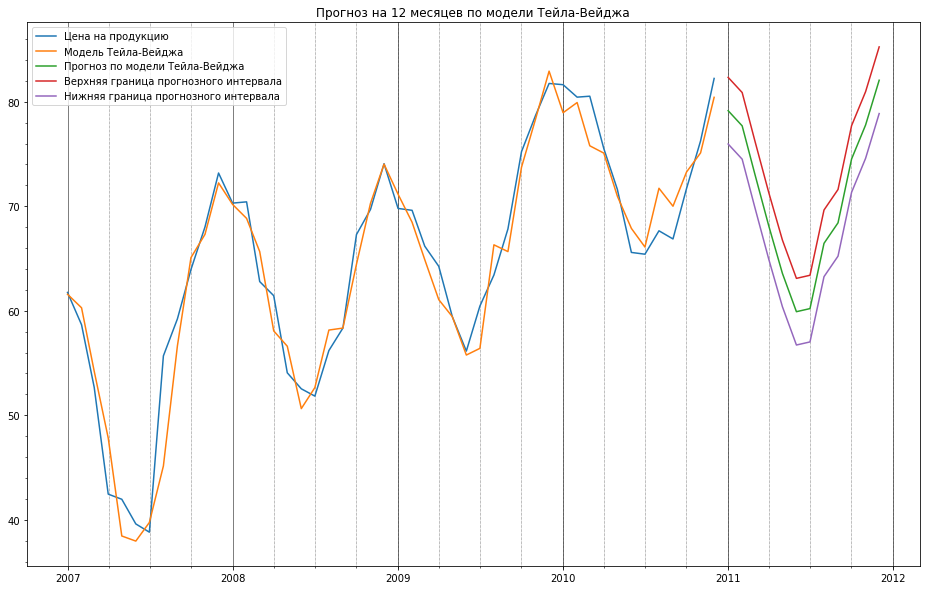

In [81]:
fig, ax = plt.subplots(figsize = (16, 10))

ax.plot(my_data['Value'], label = 'Цена на продукцию')
ax.plot(model.fittedvalues,label = 'Модель Тейла-Вейджа')
ax.plot(model.predict(start=48, end=59),label = 'Прогноз по модели Тейла-Вейджа')
ax.plot(y_up, label = 'Верхняя граница прогнозного интервала')
ax.plot(y_down, label = 'Нижняя граница прогнозного интервала')

ax.grid(which = 'major', axis = 'x', linestyle = '-', linewidth = '0.5', color = 'black')

ax.minorticks_on()

ax.grid(which = 'minor', axis = 'x', linestyle = ':', linewidth = '0.5', color = 'black')

ax.set_axisbelow(True)

ax.legend()

plt.title('Прогноз на 12 месяцев по модели Тейла-Вейджа')

plt.show()